In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.vector_ar.var_model import VAR
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Preprocessing

In [2]:
pd.set_option('display.max_columns', None)

# COVID-19 testing data
testing = pd.read_csv('https://covidtracking.com/data/download/california-history.csv')
testing.head()

,date,state,dataQualityGrade,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,inIcuCumulative,inIcuCurrently,negative,negativeIncrease,negativeTestsAntibody,negativeTestsPeopleAntibody,negativeTestsViral,onVentilatorCumulative,onVentilatorCurrently,positive,positiveCasesViral,positiveIncrease,positiveScore,positiveTestsAntibody,positiveTestsAntigen,positiveTestsPeopleAntibody,positiveTestsPeopleAntigen,positiveTestsViral,recovered,totalTestEncountersViral,totalTestEncountersViralIncrease,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,2021-01-10,CA,B,29701.0,NaN,468,NaN,NaN,NaN,22513.0,0,NaN,4965.0,33155862,423391,NaN,NaN,NaN,NaN,NaN,2670962,2670962.0,49685,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,35826824,473076,NaN,NaN,NaN,NaN,NaN,0,35826824,473076
1,2021-01-09,CA,B,29233.0,NaN,695,NaN,NaN,NaN,22600.0,0,NaN,4939.0,32732471,273782,NaN,NaN,NaN,NaN,NaN,2621277,2621277.0,52636,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,35353748,326418,NaN,NaN,NaN,NaN,NaN,0,35353748,326418
2,2021-01-08,CA,B,28538.0,NaN,493,NaN,NaN,NaN,22836.0,0,NaN,4905.0,32458689,216945,NaN,NaN,NaN,NaN,NaN,2568641,2568641.0,50030,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,35027330,266975,NaN,NaN,NaN,NaN,NaN,0,35027330,266975
3,2021-01-07,CA,B,28045.0,NaN,583,NaN,NaN,NaN,22851.0,0,NaN,4811.0,32241744,175349,NaN,NaN,NaN,NaN,NaN,2518611,2518611.0,36385,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,34760355,211734,NaN,NaN,NaN,NaN,NaN,0,34760355,211734
4,2021-01-06,CA,B,27462.0,NaN,459,NaN,NaN,NaN,22820.0,0,NaN,4731.0,32066395,187945,NaN,NaN,NaN,NaN,NaN,2482226,2482226.0,29892,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,34548621,217837,NaN,NaN,NaN,NaN,NaN,0,34548621,217837


In [3]:
# Hospital data by county if needed
hospital_url = 'https://data.ca.gov/dataset/529ac907-6ba1-4cb7-9aae-8966fc96aeef/resource/42d33765-20fd-44b8-a978-b083b7542225/download/hospitals_by_county.csv'
hospital_df = pd.read_csv(hospital_url)

In [4]:
# recovery data?
testing['recovered'].unique()

array([nan])

In [5]:
testing = testing[['date', 'totalTestResults', 'totalTestResultsIncrease']]
testing.rename(columns={'totalTestResults': 'total_tests', 'totalTestResultsIncrease': 'new_tests'}, inplace=True)
testing = testing.sort_values(by='date', ascending=True).reset_index(drop=True)
testing.head()

,date,total_tests,new_tests
0,2020-03-04,515,0
1,2020-03-05,515,0
2,2020-03-06,522,7
3,2020-03-07,531,9
4,2020-03-08,550,19


In [6]:
# NY Times time series
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
nytimes = pd.read_csv(url)
nytimes = nytimes.loc[(nytimes['date'] >= '2020-03-04') &
                      (nytimes['state'] == 'California')].reset_index(drop=True)
nytimes.head()

,date,state,fips,cases,deaths
0,2020-03-04,California,6,55,1
1,2020-03-05,California,6,67,1
2,2020-03-06,California,6,81,1
3,2020-03-07,California,6,100,1
4,2020-03-08,California,6,112,1


In [7]:
# merge testing data and NY Times data
df = pd.merge(testing, nytimes, how='inner', on='date')
df.drop(['state', 'fips'], axis=1, inplace=True)
df.rename(columns={'cases': 'total_cases', 'deaths': 'total_deaths'}, inplace=True)
df.head()

,date,total_tests,new_tests,total_cases,total_deaths
0,2020-03-04,515,0,55,1
1,2020-03-05,515,0,67,1
2,2020-03-06,522,7,81,1
3,2020-03-07,531,9,100,1
4,2020-03-08,550,19,112,1


In [8]:
# create daily cases and daily deaths columns
df['new_cases'] = df['total_cases'].diff()
df['new_deaths'] = df['total_deaths'].diff()
df.fillna(0, inplace=True)
df['new_cases'] = df['new_cases'].astype('int')
df['new_deaths'] = df['new_deaths'].astype('int')
df.head()

,date,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths
0,2020-03-04,515,0,55,1,0,0
1,2020-03-05,515,0,67,1,12,0
2,2020-03-06,522,7,81,1,14,0
3,2020-03-07,531,9,100,1,19,0
4,2020-03-08,550,19,112,1,12,0


In [9]:
# add positivity rate column
df['positivity_rate'] = df['total_cases']/df['total_tests']
df.head()

,date,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths,positivity_rate
0,2020-03-04,515,0,55,1,0,0,0.106796
1,2020-03-05,515,0,67,1,12,0,0.130097
2,2020-03-06,522,7,81,1,14,0,0.155172
3,2020-03-07,531,9,100,1,19,0,0.188324
4,2020-03-08,550,19,112,1,12,0,0.203636


In [10]:
df.to_csv('california_covid19.csv')
print(df.shape)
df.head()

(312, 8)


,date,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths,positivity_rate
0,2020-03-04,515,0,55,1,0,0,0.106796
1,2020-03-05,515,0,67,1,12,0,0.130097
2,2020-03-06,522,7,81,1,14,0,0.155172
3,2020-03-07,531,9,100,1,19,0,0.188324
4,2020-03-08,550,19,112,1,12,0,0.203636


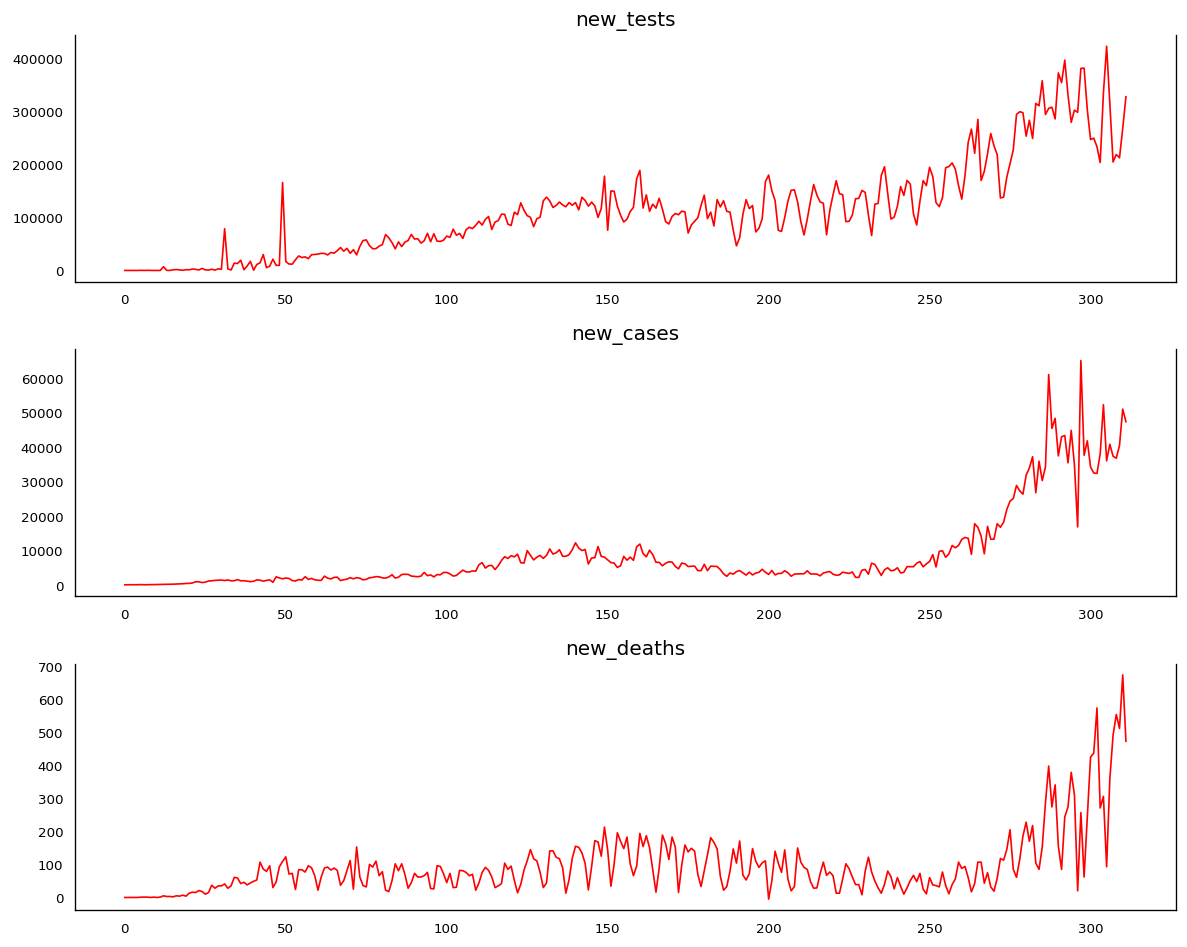

In [11]:
plot_df = df.loc[:, ['new_tests', 'new_cases', 'new_deaths']]
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,8))
plt.rc('font', size=10)
for i, ax in enumerate(axes.flatten()): 
    data = plot_df[plot_df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(plot_df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=8)
plt.tight_layout()

look into weekly trends for new deaths

take fourier transform of new deaths and then plot (start at 50 and go to 250). python package for power spectral density

## Correlation

In [12]:
# Our null hypothesis is that the correlation coefficient is not significantly different from 0.
def pearson_corr(column1, column2):
    corr_coef, p_value = pearsonr(column1, column2)
    print('correlation:', corr_coef)
    print('p value:', p_value)

def spearman_corr(column1, column2):
    corr_coef, p_value = spearmanr(column1, column2)
    print('correlation:', corr_coef)
    print('p value:', p_value)
    
pearson_corr(df['new_cases'], df['new_deaths'])

correlation: 0.7366348764796798
p value: 1.3453716372625048e-54


P-value is less than 0.05, so we can conclude there is a positive correlation between new deaths and new cases.

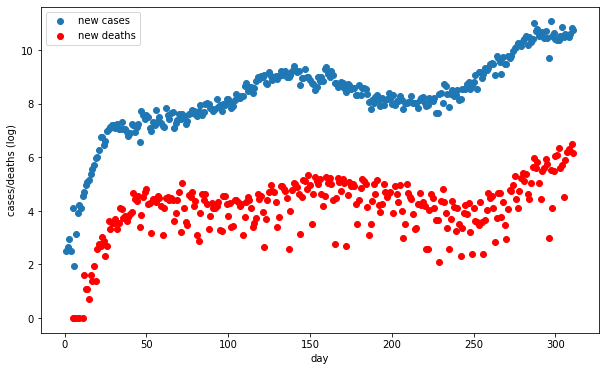

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(np.arange(0, len(df)), np.log(df['new_cases']), label='new cases')
plt.scatter(np.arange(0, len(df)), np.log(df['new_deaths']), label='new deaths', c='red')
plt.legend()
plt.xlabel('day')
plt.ylabel('cases/deaths (log)')
plt.show()

In [14]:
pearson_corr(df['positivity_rate'], df['total_deaths'])

correlation: -0.48598053657463486
p value: 6.741628415140504e-20


In [15]:
df.corr(method='spearman')

,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths,positivity_rate
total_tests,1.000000,0.908578,1.000000,0.999997,0.812735,0.433102,-0.593944
new_tests,0.908578,1.000000,0.908576,0.908568,0.852569,0.398199,-0.515344
total_cases,1.000000,0.908576,1.000000,0.999997,0.812736,0.433103,-0.593940
total_deaths,0.999997,0.908568,0.999997,1.000000,0.812747,0.433198,-0.593969
new_cases,0.812735,0.852569,0.812736,0.812747,1.000000,0.580641,-0.418351
new_deaths,0.433102,0.398199,0.433103,0.433198,0.580641,1.000000,-0.008455
positivity_rate,-0.593944,-0.515344,-0.593940,-0.593969,-0.418351,-0.008455,1.000000


## Cases model

In [16]:
cases_df = df[['new_tests', 'total_cases', 'new_cases', 'new_deaths', 'positivity_rate']]
cases_df.shape

(312, 5)

In [17]:
cases_df = cases_df.iloc[0:151]
cases_df.head()

,new_tests,total_cases,new_cases,new_deaths,positivity_rate
0,0,55,0,0,0.106796
1,0,67,12,0,0.130097
2,7,81,14,0,0.155172
3,9,100,19,0,0.188324
4,19,112,12,0,0.203636


In [18]:
cases_model = VAR(cases_df)
model_fit = cases_model.fit()
prediction = model_fit.forecast(model_fit.y, steps=50)
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 10, Jan, 2021
Time:                     22:58:07
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    12.7871
Nobs:                     150.000    HQIC:                   12.4296
Log likelihood:          -1948.07    FPE:                    195858.
AIC:                      12.1849    Det(Omega_mle):         66232.3
--------------------------------------------------------------------
Results for equation new_tests
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                  24242.460023      5515.122307            4.396           0.000
L1.new_tests               0.143231         0.089617            1.598           0.110
L1.total_cases             0.120604 

In [19]:
pred_df = pd.DataFrame(prediction, columns=cases_df.columns)
#pred_df['total_tests'] = pred_df['total_tests'].astype('int64')
pred_df['new_tests'] = pred_df['new_tests'].astype('int64')
pred_df['total_cases'] = pred_df['total_cases'].astype('int64')
pred_df['new_cases'] = pred_df['new_cases'].astype('int64')
pred_df['date_range'] = np.arange(len(cases_df), len(cases_df)+len(pred_df))
pred_df['date'] = pd.date_range(start=df['date'][151], periods=len(pred_df), freq='D')
print(pred_df.shape)
pred_df.head()

(50, 7)


,new_tests,total_cases,new_cases,new_deaths,positivity_rate,date_range,date
0,119034,517205,7698,134.903113,0.068220,151,2020-08-02
1,129300,525705,8499,135.893488,0.062491,152,2020-08-03
2,136750,534881,9176,137.030613,0.056212,153,2020-08-04
3,143203,544625,9743,138.233202,0.050079,154,2020-08-05
4,148942,554856,10230,139.619511,0.044231,155,2020-08-06


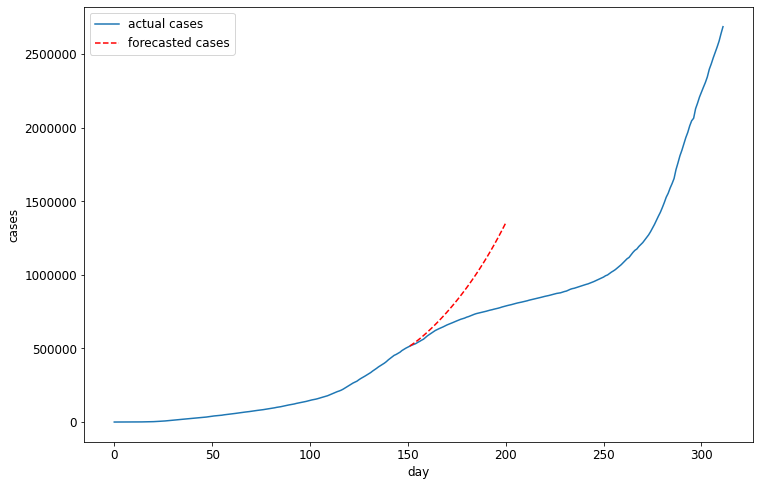

In [20]:
plt.figure(figsize=(12,8))
plt.rc('font', size=12)
plt.plot(np.arange(0, len(df)), df['total_cases'], label='actual cases')
plt.plot(pred_df['date_range'], pred_df['total_cases'], '--', label='forecasted cases', c='red')
plt.xlabel('day')
plt.ylabel('cases')
plt.legend()
plt.ticklabel_format(style='plain', axis='y')
plt.show()

## Deaths models

### Traditional model using training and testing data

In [21]:
deaths_df = df[['new_tests', 'total_deaths', 'new_cases', 'new_deaths', 'positivity_rate']]
deaths_df.shape

(312, 5)

In [22]:
train, test = np.split(deaths_df, [int(.8 *len(deaths_df))])
print(train.shape, test.shape)

(249, 5) (63, 5)


In [23]:
deaths_model = VAR(train)
model_fit = deaths_model.fit()
prediction = model_fit.forecast(model_fit.y, steps=len(test))
pred_df = pd.DataFrame(prediction, columns=deaths_df.columns)
pred_df.head()

,new_tests,total_deaths,new_cases,new_deaths,positivity_rate
0,161396.063771,18023.704572,5423.630392,59.704572,0.048428
1,154983.614287,18100.172898,5545.165462,76.468326,0.045920
2,151461.397512,18184.325557,5603.409384,84.152659,0.043376
3,149950.318166,18271.929443,5629.831872,87.603886,0.041108
4,149533.704875,18361.108113,5642.618333,89.178670,0.039154


In [24]:
pred_df['new_tests'] = pred_df['new_tests'].astype('int64')
pred_df['new_cases'] = pred_df['new_cases'].astype('int64')
print(pred_df.shape)
pred_df.head()

(63, 5)


,new_tests,total_deaths,new_cases,new_deaths,positivity_rate
0,161396,18023.704572,5423,59.704572,0.048428
1,154983,18100.172898,5545,76.468326,0.045920
2,151461,18184.325557,5603,84.152659,0.043376
3,149950,18271.929443,5629,87.603886,0.041108
4,149533,18361.108113,5642,89.178670,0.039154


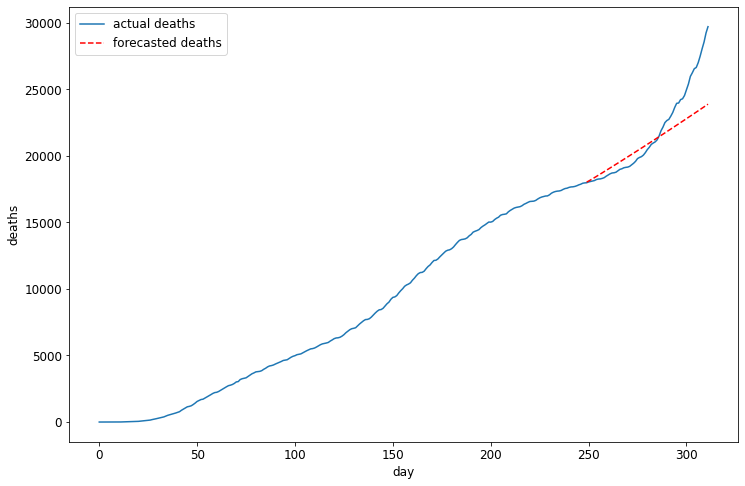

In [25]:
plt.figure(figsize=(12,8))
plt.rc('font', size=12)
plt.plot(np.arange(0, len(deaths_df)), deaths_df['total_deaths'], label='actual deaths')
plt.plot(np.arange(len(train), len(train)+len(pred_df)), pred_df['total_deaths'], 
         '--', label='forecasted deaths', c='red')
plt.xlabel('day')
plt.ylabel('deaths')
plt.legend()
plt.show()

### Model that uses a specified number of time series intervals

In [34]:
def plot(title):
    plt.figure(figsize=(10,6))
    plt.rc('font', size=12)
    plt.plot(np.arange(0, len(deaths_df)), deaths_df['total_deaths'], label='actual deaths')
    plt.plot(np.arange(0, len(pred_df)), pred_df['total_deaths'], '--', label='forecasted deaths', c='red')
    plt.xlabel('day')
    plt.ylabel('deaths')
    plt.legend()
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(title)
    plt.show()

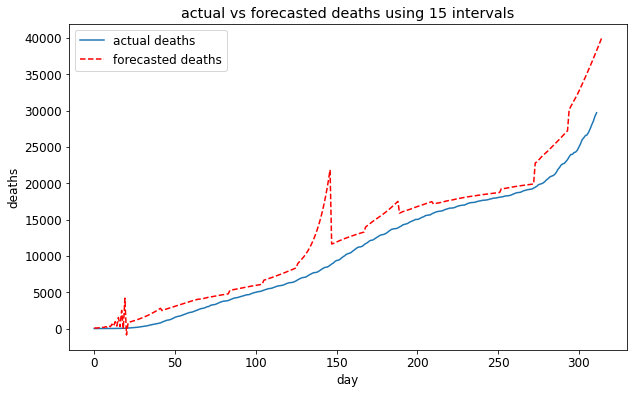

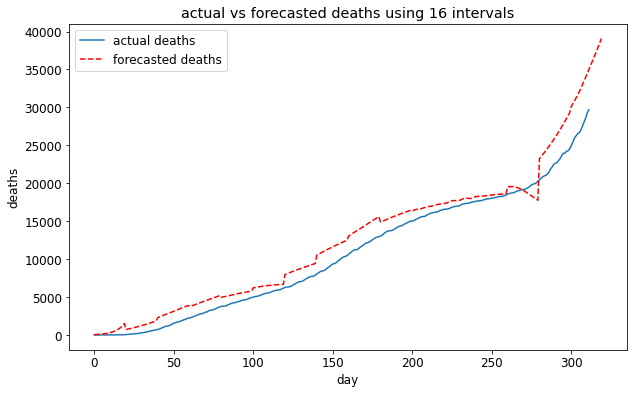

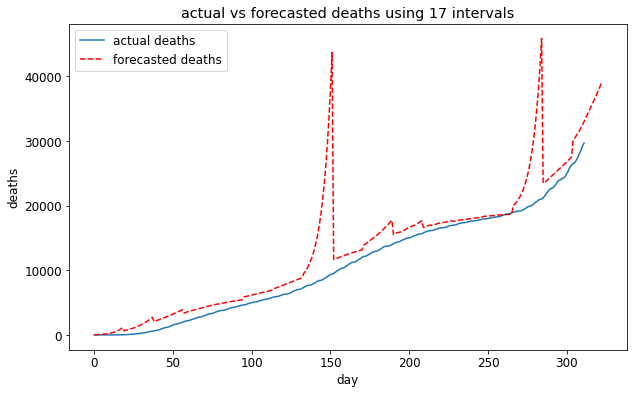

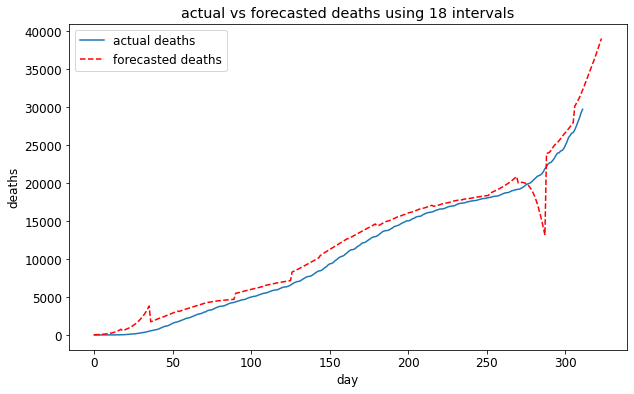

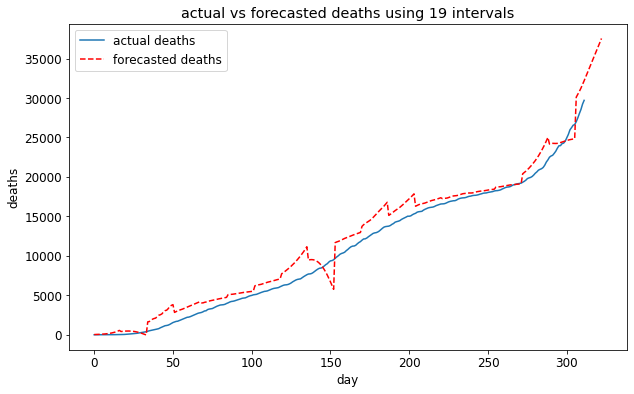

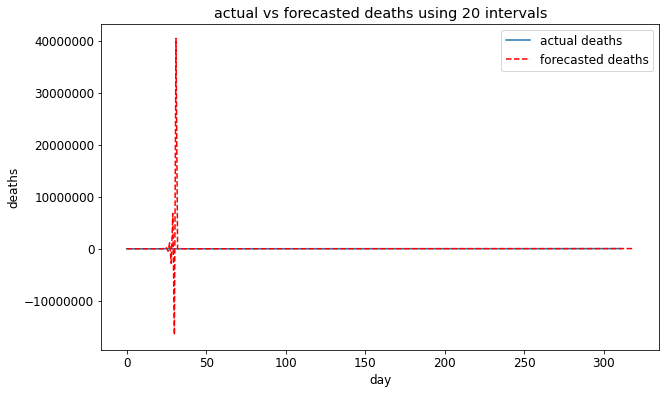

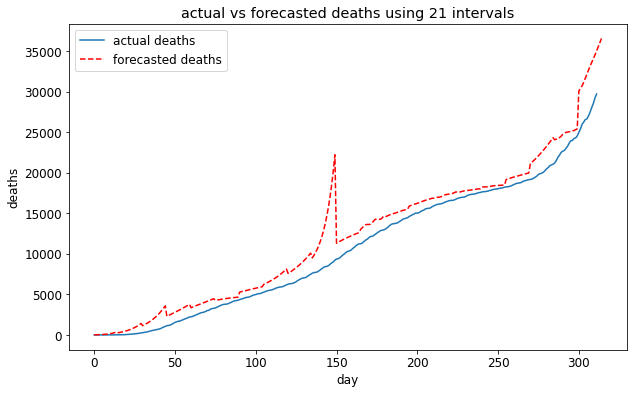

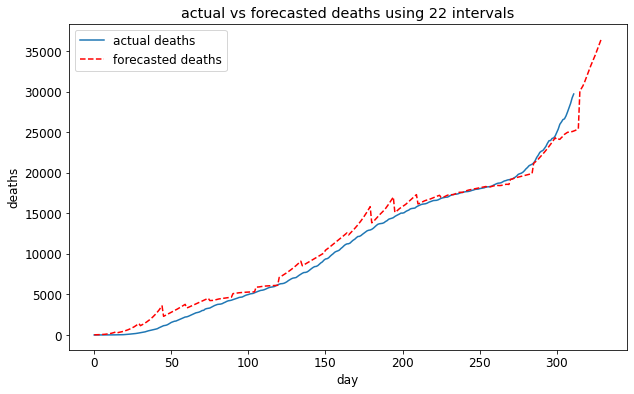

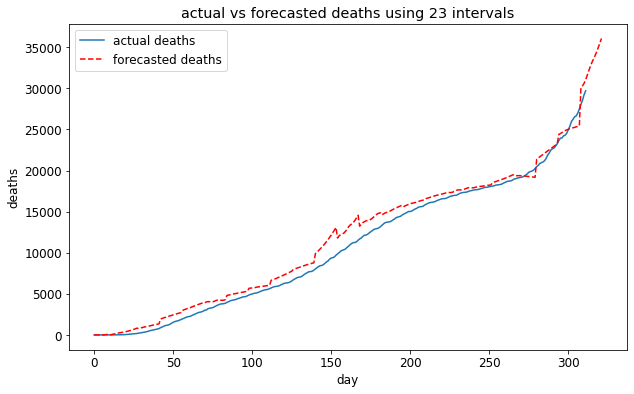

In [35]:
num_intervals = list(range(15, 24)) 
for i in num_intervals:  
    split_df = np.array_split(deaths_df, i) # splits data into certain number of intervals
    cols = ['new_tests', 'total_deaths', 'new_cases', 'new_deaths', 'positivity_rate']
    pred_df = pd.DataFrame(columns=cols) # create empty df for predictions
    
    # predict for each df in the split df and append predictions to empty df
    for df in split_df:
        deaths_model = VAR(df)
        model_fit = deaths_model.fit()
        prediction = pd.DataFrame(model_fit.forecast(model_fit.y, steps=len(split_df[0])), columns=cols)
        pred_df = pred_df.append(prediction, ignore_index=True)
    pred_df['new_tests'] = pred_df['new_tests'].astype('int64')
    pred_df['total_deaths'] = pred_df['total_deaths'].astype('int64')
    pred_df['new_cases'] = pred_df['new_cases'].astype('int64')
    pred_df['new_deaths'] = pred_df['new_deaths'].astype('int64')
    plot('actual vs forecasted deaths using {} intervals'.format(i))

The model is predicting a negative number of new deaths for certain days.

## County Data

In [28]:
# url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
# url = 'https://data.ca.gov/dataset/590188d5-8545-4c93-a9a0-e230f0db7290/resource/926fd08f-cc91-4828-af38-bd45de97f8c3/download/statewide_cases.csv'
# df = pd.read_csv(url)
# df.rename(columns={'totalcountconfirmed': 'total_cases', 'totalcountdeaths': 'total_deaths', 
#                    'newcountconfirmed': 'new_cases', 'newcountdeaths': 'new_deaths'}, inplace=True)
# df.head()

In [29]:
# def create_county_data(county_name):
#     county = df.loc[df['county'] == county_name].reset_index(drop=True)
#     county['day'] = np.arange(0, len(county['date']))
#     return county

# sample = create_county_data('Los Angeles')
# sample